In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Positional Encoding

#### why?

Position and order of words are the essential parts of any language. They define the grammar and semantics of a sentence. Recurrent Neural Networks (RNN's) parse a sentence word by word in a sequential manner. This will integrate the words order in the backbone of RNNs.

But the Transformer architecture removes the recurrence mechanism in favor of multi-head self-attention mechanism. Avoiding the RNN's method of recurrence will result in massive speed-up in the training time. And theoretically, it can capture longer dependencies in a sentence.

As each word in a sentence simultaneously flows through the Transformer's encoder/decoder stack, The model itself doesn't have any sense of position/order for each word. Consequently, there's still the need for a way to incorporate the order of the words into our model.

for example let consider a sentence "xyz bank is located directly opposite to the abc bank" the naive transformer block will assign same weightage to the word bank in 2nd position and last position. Even though both the words have same semantic representation but they are placed in different position. So the word opposite should show higher attention to the word bank in last than 2nd position word. There is a need to incorporate such information into the model.   

#### how?
One possible solution to give the model some sense of order is to add a piece of information to each word about its position in the sentence. It can be done by adding positional information along with the embedding.

#### Approaches

##### Naive approach
Most basic approach is adding the numerical position of the token in a sequence along with the token embedding. (ie)., let consider our sequence be $A = \{a_1, a_2, ... a_i\}$ then we can map each token with its corresponding index $a_i \to i$.

$$\begin{matrix}a_0 & a_1 & a_2 & a_3 & a_4 & a_5 \\ 0 & 1 & 2 & 3 & 4 & 5 \end{matrix}$$

The problem with this approach is that the values could get quite large, also our model may not see any sample with one specific length which would hurt generalization of our model. It may also pay way to exploding gradients problem.

##### Normalized Index

So we want to represent the position which lies between 0 and 1. for that we can divide each index by sequence length.

$$\begin{matrix}a_0 & a_1 & a_2 & a_3 & a_4 & a_5 \\ \frac{0}{6} & \frac{1}{6} & \frac{2}{6} & \frac{3}{6} & \frac{4}{6} & \frac{5}{6} \\ 0 & 0.17 & 0.33 & 0.5 & 0.67 & 0.83\end{matrix}$$

Now we got some normalized representation [0,1] which avoids problems that we faced in naive approach but we can not able to deal with arbitrary sequence length. That's because each of these entries is divided by the sequence length. A positional encoding value of say 0.8 means a totally different thing to a sequence of length 5 than it does for one of length 10.

$$\begin{matrix}a_0 & a_1 & a_2 & a_3 & a_4 & a_5 \\ 0 & 0.17 & 0.33 & 0.5 & 0.67 & 0.83\end{matrix}$$

$$\begin{matrix}a_0 & a_1 & a_2 & a_3 & a_4 & a_5 & a_6 & a_7 & a_8 & a_9 & a_{10} \\ 0 & 0.09 & 0.18 & 0.27 & 0.36 & 0.45 & 0.54 & 0.63 & 0.73 & 0.81 & 0.9\end{matrix}$$


Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word's position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- The positional encoding should enable the model to infer the relative position.

#### Proposed method

Let t be the desired position in an input sentence, $\vec p_t$,$t \in \mathbb{R}^d$  be its corresponding encoding, and d be the encoding dimension (where d is divisible of 2) Then $f:\mathbb{N} \to \mathbb{R}^d$ will be the function that produces the output vector $\vec p_t$ and it is defined as follows:

$$\vec p_t^{(i)} = f(t)^ {(i)} = \begin{cases}\sin(w_k.t), \text{if } i = 2k \\ \cos(w_k.t), \text{if } i = 2k+1 \end{cases}$$

where

$$w_k = \frac{1}{10000^{{2k /\ d}}}$$

As it can be derived from the function definition, the frequencies are decreasing along the vector dimension. Thus it forms a geometric progression from $2\pi$ to $10000⋅2\pi$ on the wavelengths.



##### Analysis


let consider we are taken a single tooth wheel and we going to calculate the position of the point in the wheel at each time-step and we use such position of the point in time space. 

<img src ="images/sinusoidal_curve.png" width= 300 height=200>

so to delay the time of collision we can reduce the frequency of the rotation.

let $G_1, G_2$ be the two gears, $G_1$ will complete one rotation in $2\pi$ time-step and $G_2$ will complete one rotation in $20 * 2\pi$ so we can define a function for two gear as

Equation for $G_1$
$$y_1 = \sin(2\pi* \frac{1}{2\pi}*t), \text{where $1/2\pi$ is a frequency and t is the time-step} $$

which can be written as 

$$y_1 = \sin(t)$$

therefore the equation of $G_2$ can be define as,

$$y_2 = \sin(\frac{1}{20}*t)$$

sin wave of two gears is plotted bellow

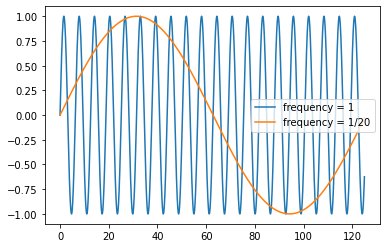

In [2]:
plt.plot(np.arange(0, 125, 0.01), np.sin(np.arange(0, 125, 0.01)))
plt.plot(np.arange(0, 125, 0.01), np.sin(np.arange(0, 125, 0.01)*(1/20)))
plt.legend(['frequency = 1', 'frequency = 1/20'])

from above work we can see that increase the wavelength (time taken to complete one rotation) will help us to have get unique representation for each time-step for some extended time. But still it does not satisfies the second constraint (Distance between any two time-steps should be consistent across sentences with different lengths).

Instead of finding one dead slow gear with high wavelength we can have n number of gears with different frequency as n increases time take to have collision also increases.

first let create a function to increase the wavelength of the each gears ie., the first gear will have high frequency and the last gear will have low frequency. so we need a function which is  monotonically increasing nature to represent the wave length.
           $$\lambda = x^{2i / d}$$
           
The author choose x as 10000. therefore,
           $$\lambda = 10000^{2i / d}$$
           
where d = 2 * no of gears

let no of gears be 10. then d = 20

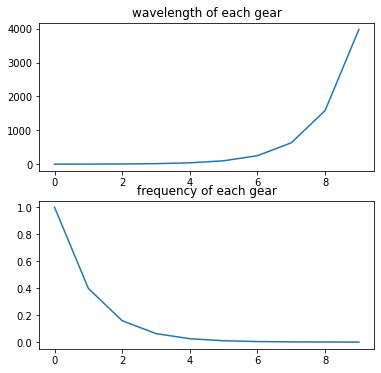

In [3]:
x = np.arange(10)
y = 10000 ** (2*(x)/(2 * len(x)))

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.title('wavelength of each gear')
plt.plot(x, y)


plt.subplot(212)
plt.title('frequency of each gear')
plt.plot(x, 1/y)
plt.show()

we can see that the frequency of gear decreases as position of gear increases. where frequency = $1/\lambda$.

Now we can calculate the fixed point of each gear for every time-step "t".
To calculate the coordinate position of the point in the circle is calculated by,
$$p = (\cos(\theta), \sin(\theta))$$

![image_2](images/unit_circle_sinisoid.png)

now we can represent the positional vector with d dimensional vector at time t(sequence length, 2* no of gears).

$$\vec p_t = [\cos(t.\omega_1), \sin(t_1.\omega_1), \cos(t.\omega_2), \sin(t_1.\omega_2), \dots, \cos(t.\omega_n), \sin(t_1.\omega_n)]$$

where $\omega_n$ is the frequency of the gear at position n.

---

Finally, now we got some positional representation. we have to verify whether it is satisfying all constraints.

**Is it outputs unique encoding for each time-step?**

yes, we can represent each time-step uniquely to a certain period. consider clock hands (hour, minute, and second hand) are three different gears with three different frequency. All hands will have collision 11 times for every 12 hour. so we will have repeated pattern after 43200 seconds (12 * 60 * 60). like wise this approach will have such point but it is directly proportional to the d / 2.

In [5]:
import numpy as np
import seaborn as sns


def montanicaly_increasing_function(d_model):
    return 2*(np.arange(d_model)//2)/d_model

def get_angles(d_model, min_freq):
    angle_rates = 1 / np.power(min_freq, montanicaly_increasing_function(d_model))
    return angle_rates

def positional_encoding(max_position, d_model, min_freq=10000):
    position = np.arange(max_position)
    freqs = get_angles(d_model, min_freq)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc

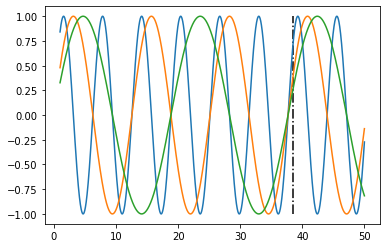

In [49]:
## Below plot represent the pattern repeation over 3 dimention

a = np.arange(1, 50, 0.01)
plt.plot(a, np.sin(a))
plt.plot(a, np.sin(a*(1/2)))
plt.plot(a, np.sin(a*(1/3)))
plt.vlines(x = 38.5,ymin= -1, ymax = 1, linestyles = 'dashdot', color = 'black')

**Is distance between any two time-steps should be consistent across sentences with different lengths?**

yes, our frequency vector doest have any direct impact of position 't'. so the position encoding of two different sequence with same dimension size will have consistent encoding across time-step.

In [79]:
#### s_1 : (10, 30); s_2 : (20, 30)

try:
    assert np.all(positional_encoding(10, 30)[1] == positional_encoding(20, 30)[1])
    assert np.all(positional_encoding(10, 30)[9] == positional_encoding(20, 30)[9])
    print('two sequence with different sequences length and same dimensions have consistent representation')
except AssertionError:
    print('two sequence with different sequences length and same dimensions have no consistent representation')
    
#### s_1 : (10, 30); s_2 : (10, 40)

try:
    assert np.all(positional_encoding(10, 30)[1] == positional_encoding(10, 40)[1])
    assert np.all(positional_encoding(10, 30)[9] == positional_encoding(10, 40)[9])
    print('two sequence with different sequence length and same dimensions have consistent representation')
except AssertionError:
    print('two sequences with same sequence length and different dimensions have no consistent representation')


two sequence with different sequences length and same dimensions have consistent representation
two sequences with same sequence length and different dimensions have no consistent representation


/tmp/ipykernel_16672/163795696.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert np.all(positional_encoding(10, 30)[1] == positional_encoding(10, 40)[1])


**Is our model able to generalize to longer sentences without any efforts**

yes, the distance between neighboring time-steps are symmetrical and decays nicely with time. so model can easily generalize to longer sentences.

sinusoidal function values are always bounded between -1 to 1.

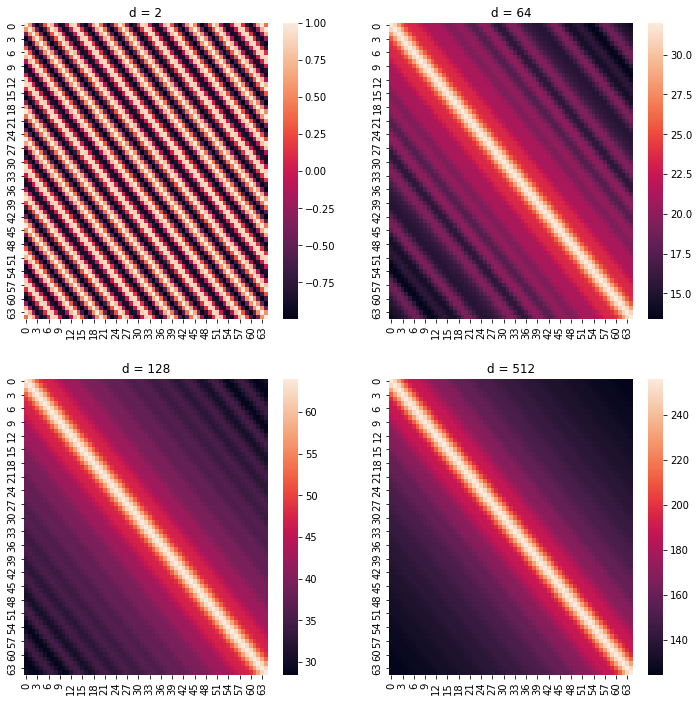

In [89]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.title('d = 2')
a = positional_encoding(65, 2)
sns.heatmap(a.dot(a.T))

plt.subplot(222)
plt.title('d = 64')
a = positional_encoding(65, 64)
sns.heatmap(a.dot(a.T))

plt.subplot(223)
plt.title('d = 128')
a = positional_encoding(65, 128)
sns.heatmap(a.dot(a.T))

plt.subplot(224)
plt.title('d = 512')
a = positional_encoding(65, 512)
sns.heatmap(a.dot(a.T))

plt.show()

we can see that symmetrical and smooth decays is depends on dimension size.

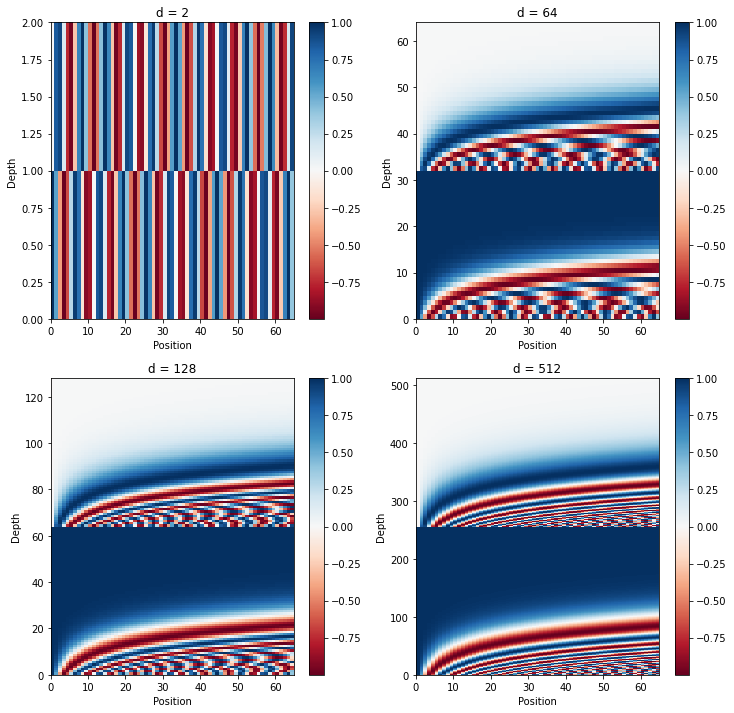

In [95]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
plt.title('d = 2')
pos_encoding = positional_encoding(65, 2)
pos_encoding = np.reshape(pos_encoding, (65, 2//2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (2, 65))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
# sns.heatmap(a)

plt.subplot(222)
plt.title('d = 64')
pos_encoding = positional_encoding(65, 64)
pos_encoding = np.reshape(pos_encoding, (65, 64//2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (64, 65))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()

plt.subplot(223)
plt.title('d = 128')
d = 128
pos_encoding = positional_encoding(65, d)
pos_encoding = np.reshape(pos_encoding, (65, d//2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (d, 65))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()

plt.subplot(224)
plt.title('d = 512')
d = 512
pos_encoding = positional_encoding(65, d)
pos_encoding = np.reshape(pos_encoding, (65, d//2, 2))
pos_encoding = np.transpose(pos_encoding, (2, 1, 0))
pos_encoding = np.reshape(pos_encoding, (d, 65))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()

**Is the positional encoding enables the model to infer the relative position?**

Another characteristic of sinusoidal positional encoding is that it allows the model to attend relative positions effortlessly. Here is a quote from the original paper:

>We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset k, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

For every sine-cosine pair corresponding to frequency $\omega_k$, there is a linear transformation 
$M \in \mathbb{R}^{2×2}$ (independent of t) where the following equation holds:

$$M \begin{bmatrix} \sin(\omega_k.t) \\ \cos(\omega_k.t)\end{bmatrix} = \begin{bmatrix} \sin(\omega_k.(t + \phi)) \\ \cos(\omega_k.(t + \phi))\end{bmatrix}$$

Proof:

Let M be a 2×2 matrix, we want to find $u_1$, $v_1$, $u_2$ and $v_2$ so that:

$$\begin{bmatrix} u_1 & v_1 \\ u_2 & v_2\end{bmatrix} \begin{bmatrix} \sin(\omega_k.t) \\ \cos(\omega_k.t)\end{bmatrix} = \begin{bmatrix} \sin(\omega_k.(t + \phi)) \\ \cos(\omega_k.(t + \phi))\end{bmatrix}$$

By applying the addition theorem,
$$\sin(A+B) = \sin(A)\cos(B) + \cos(A)\sin(B)$$
$$\cos(A+B) = \cos(A)\cos(B) - \sin(A)\sin(B)$$

$$\begin{bmatrix} u_1 & v_1 \\ u_2 & v_2\end{bmatrix} \begin{bmatrix} \sin(\omega_k.t) \\ \cos(\omega_k.t)\end{bmatrix} = \begin{bmatrix} \sin(\omega_k.t)\cos(\phi.\omega_k) + \cos(\omega_k.t)\sin(\phi.\omega_k) \\ \cos(\omega_k.t)\cos(\phi.\omega_k) - \sin(\omega_k.t)\sin(\phi.\omega_k)\end{bmatrix}$$


Which result in the following two equations:

$$u_1\sin(\omega_k.t) + v_1\cos(\omega_k.t) = \sin(\omega_k.t)\cos(\phi.\omega_k) + \cos(\omega_k.t)\sin(\phi.\omega_k)$$

$$u_2\sin(\omega_k.t) + v_2\cos(\omega_k.t) = \cos(\omega_k.t)\cos(\phi.\omega_k) - \sin(\omega_k.t)\sin(\phi.\omega_k)$$
 
By solving above equations, we get:

$$M = \begin{bmatrix} \cos(\phi.\omega_k) & \sin(\phi.\omega_k) \\ -\sin(\phi.\omega_k) &\cos(\phi.\omega_k)\end{bmatrix}$$


As you can see, the final transformation does not depend on t. Note that one can find the matrix M very similar to the rotation matrix.

Similarly, we can find M for other sine-cosine pairs, which eventually allows us to represent $\vec p_t + \phi$ as a linear function of $\vec p_t$ for any fixed offset $\phi$. This property, makes it easy for the model to learn to attend by relative positions.